In [1]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np

from einops import rearrange

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
resnet_pretrained = models.resnet18(pretrained=True)
resnet_pretrained.fc = torch.nn.Identity()

resnet_pretrained_frozen = models.resnet18(pretrained=True)
resnet_pretrained_frozen.fc = torch.nn.Identity()

#load prior tasks
labels_list = np.load('labels_list_new_algo_1.npy')

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# ── 1. Build a “multi-label” view of the data ──────────────────────────────────
labels_matrix = np.stack(labels_list)          # (100, N)
labels_matrix = torch.from_numpy(labels_matrix).float()  # to tensor

class MultiTaskWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, all_labels):
        self.base_ds   = base_ds               # the dataset behind your test_loader
        self.all_lbls  = all_labels            # (100, N)
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, idx):
        img, _    = self.base_ds[idx]
        lbl_vec   = self.all_lbls[:, idx]      # (100,)
        return img, lbl_vec

multi_ds     = MultiTaskWrapper(test_loader.dataset, labels_matrix)
multi_loader = torch.utils.data.DataLoader(multi_ds,
                                           batch_size=test_loader.batch_size,
                                           shuffle=False,
                                           num_workers=test_loader.num_workers,
                                           pin_memory=True)

# ── 2. Multi-task linear probe ─────────────────────────────────────────────────
def linear_probe_multi(model, loader, n_epoch=1):
    feat_dim   = 512              # resnet head size
    n_tasks    = 100
    model.eval().cuda()

    head = torch.nn.Linear(feat_dim, n_tasks).cuda()
    crit = torch.nn.BCEWithLogitsLoss()
    opt  = torch.optim.Adam(head.parameters(), lr=1e-2)

    for epoch in trange(n_epoch):
        runloss = 0.
        for imgs, lbls in loader:                  # lbls → (B, 100)
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():        # mixed precision, optional
                feats   = model(imgs)              # (B, 1000)
                logits  = head(feats)              # (B, 100)
                loss    = crit(logits, lbls)
            loss.backward()
            opt.step()
            runloss += loss.item()

        print(f'Epoch {epoch+1}: loss = {runloss/len(loader):.4f}')

    # ─ Evaluation per task ─
    correct = torch.zeros(n_tasks, device='cuda')
    total   = torch.zeros(n_tasks, device='cuda')

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            preds   = (head(model(imgs)) > 0).float()
            correct += (preds == lbls).sum(dim=0)
            total   += lbls.size(0)

    acc = (100*correct/total).cpu().numpy()        # shape (100,)
    print(f'Mean accuracy over 100 tasks: {acc.mean():.2f}%')
    return acc

# ── 3. Run it ──────────────────────────────────────────────────────────────────
pre_task_accuracies = linear_probe_multi(resnet_pretrained, multi_loader, n_epoch=30)


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_8924/662220567.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


Epoch 1: loss = 0.7658
Epoch 2: loss = 0.7054
Epoch 3: loss = 0.6614
Epoch 4: loss = 0.6708
Epoch 5: loss = 0.6681
Epoch 6: loss = 0.6724
Epoch 7: loss = 0.6739
Epoch 8: loss = 0.6759
Epoch 9: loss = 0.6771
Epoch 10: loss = 0.6781
Epoch 11: loss = 0.6787
Epoch 12: loss = 0.6792
Epoch 13: loss = 0.6795
Epoch 14: loss = 0.6798
Epoch 15: loss = 0.6799
Epoch 16: loss = 0.6800
Epoch 17: loss = 0.6801
Epoch 18: loss = 0.6801
Epoch 19: loss = 0.6801
Epoch 20: loss = 0.6801
Epoch 21: loss = 0.6801
Epoch 22: loss = 0.6801
Epoch 23: loss = 0.6801
Epoch 24: loss = 0.6801
Epoch 25: loss = 0.6801
Epoch 26: loss = 0.6801
Epoch 27: loss = 0.6801
Epoch 28: loss = 0.6801
Epoch 29: loss = 0.6801
Epoch 30: loss = 0.6801
Mean accuracy over 100 tasks: 65.44%


(array([ 2.,  0.,  2.,  8.,  5.,  5.,  2.,  5.,  5.,  8., 10.,  9.,  9.,
         7.,  5.,  6.,  3.,  3.,  3.,  3.]),
 array([55.27000046, 56.23500061, 57.20000076, 58.16500092, 59.13000107,
        60.09500122, 61.06000137, 62.02500153, 62.99000168, 63.95500183,
        64.91999817, 65.88500214, 66.84999847, 67.81500244, 68.77999878,
        69.74500275, 70.70999908, 71.67500305, 72.63999939, 73.60500336,
        74.56999969]),
 <BarContainer object of 20 artists>)

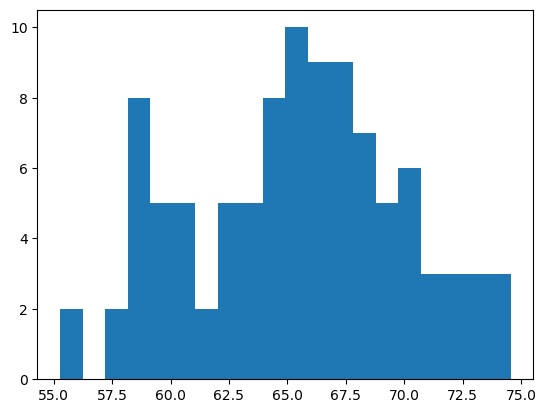

In [4]:
plt.hist(pre_task_accuracies, bins=20)

In [5]:
def compute_expectation_variance(K, M, T=1.0):
    if K.shape != M.shape:
        raise ValueError("K and M must have the same shape.")

    sigma = torch.sigmoid(K / T)              # σ(K_{ij}/T)
    expectation = (M * sigma).sum()           # Σ M σ
    variance = ((M**2) * sigma * (1 - sigma)).sum()  # Σ M² σ(1−σ)

    return expectation, variance  

In [ ]:
beta = 1
T = 1

n_epoch = 30

resnet_pretrained.train()
resnet_pretrained_frozen.eval()

optimizer = torch.optim.Adam(resnet_pretrained.parameters(), lr=0.001)

resnet_pretrained.cuda()
resnet_pretrained_frozen.cuda()

for epoch in range(n_epoch):  
    running_loss = 0.0
    running_exp = 0.0
    running_var = 0.0
    n = 0

    for images, labels in train_loader:
        images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
        images = images.cuda()

        with torch.no_grad():
            outputs = resnet_pretrained_frozen(images)

            norm_outputs = outputs / outputs.norm(dim=1, keepdim=True)
            K = norm_outputs @ norm_outputs.T
            
        outputs = resnet_pretrained(images)

        norm_outputs = outputs / outputs.norm(dim=1, keepdim=True)
        M = norm_outputs @ norm_outputs.T

        exp, var = compute_expectation_variance(K, M, T)

        loss = beta * var -  exp

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print statistics  

        running_loss += loss.item()
        running_exp += exp.item()
        running_var += var.item()

        n += 1

    print(f'Epoch {epoch+1}, Loss: {running_loss/n:.4f}, Expectation: {running_exp/n:.4f}, Variance: {running_var/n:.4f}')

Epoch 1, Loss: -115708.8025, Expectation: 172635.4919, Variance: 56926.6892
Epoch 2, Loss: -116346.1586, Expectation: 174091.6016, Variance: 57745.4430
Epoch 3, Loss: -116345.1238, Expectation: 174091.3261, Variance: 57746.2024
Epoch 4, Loss: -116344.9088, Expectation: 174091.3853, Variance: 57746.4763
Epoch 5, Loss: -116344.8603, Expectation: 174091.4995, Variance: 57746.6393
Epoch 6, Loss: -116346.5906, Expectation: 174092.8988, Variance: 57746.3080
Epoch 7, Loss: -116344.2360, Expectation: 174091.1811, Variance: 57746.9446
Epoch 8, Loss: -116345.7895, Expectation: 174092.4227, Variance: 57746.6330
Epoch 9, Loss: -116343.9963, Expectation: 174091.0832, Variance: 57747.0871
Epoch 10, Loss: -116343.9059, Expectation: 174091.0627, Variance: 57747.1567
Epoch 11, Loss: -116347.9816, Expectation: 174094.1070, Variance: 57746.1254
Epoch 12, Loss: -116343.6088, Expectation: 174090.8527, Variance: 57747.2439
Epoch 13, Loss: -116343.4186, Expectation: 174090.7036, Variance: 57747.2851
Epoch 14

KeyboardInterrupt: 

In [7]:
from datetime import datetime

# Save the fine-tuned ResNet backbone with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"resnet_pretrained_finetuned_{timestamp}.pth"
torch.save(resnet_pretrained.state_dict(), filename)
print(f"Model state_dict saved to {filename} at {timestamp}")

Model state_dict saved to resnet_pretrained_finetuned_20250507_004035.pth at 20250507_004035


In [8]:
import torch, numpy as np
from einops import rearrange

# ── 1. Build a “multi-label” view of the data ──────────────────────────────────
labels_matrix = np.stack(labels_list)          # (100, N)
labels_matrix = torch.from_numpy(labels_matrix).float()  # to tensor

class MultiTaskWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, all_labels):
        self.base_ds   = base_ds               # the dataset behind your test_loader
        self.all_lbls  = all_labels            # (100, N)
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, idx):
        img, _    = self.base_ds[idx]
        lbl_vec   = self.all_lbls[:, idx]      # (100,)
        return img, lbl_vec

multi_ds     = MultiTaskWrapper(test_loader.dataset, labels_matrix)
multi_loader = torch.utils.data.DataLoader(multi_ds,
                                           batch_size=test_loader.batch_size,
                                           shuffle=False,
                                           num_workers=test_loader.num_workers,
                                           pin_memory=True)

# ── 2. Multi-task linear probe ─────────────────────────────────────────────────
def linear_probe_multi(model, loader, n_epoch=1):
    feat_dim   = 512              # resnet head size
    n_tasks    = 100
    model.eval().cuda()

    head = torch.nn.Linear(feat_dim, n_tasks).cuda()
    crit = torch.nn.BCEWithLogitsLoss()
    opt  = torch.optim.Adam(head.parameters(), lr=1e-3)

    for epoch in range(n_epoch):
        runloss = 0.
        for imgs, lbls in loader:                  # lbls → (B, 100)
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():        # mixed precision, optional
                feats   = model(imgs)              # (B, 1000)
                logits  = head(feats)              # (B, 100)
                loss    = crit(logits, lbls)
            loss.backward()
            opt.step()
            runloss += loss.item()

        print(f'Epoch {epoch+1}: loss = {runloss/len(loader):.4f}')

    # ─ Evaluation per task ─
    correct = torch.zeros(n_tasks, device='cuda')
    total   = torch.zeros(n_tasks, device='cuda')

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            preds   = (head(model(imgs)) > 0).float()
            correct += (preds == lbls).sum(dim=0)
            total   += lbls.size(0)

    acc = (100*correct/total).cpu().numpy()        # shape (100,)
    print(f'Mean accuracy over 100 tasks: {acc.mean():.2f}%')
    return acc

# ── 3. Run it ──────────────────────────────────────────────────────────────────
task_accuracies = linear_probe_multi(resnet_pretrained, multi_loader, n_epoch=30)


/tmp/ipykernel_8924/2065752776.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


Epoch 1: loss = 0.7010
Epoch 2: loss = 0.6949
Epoch 3: loss = 0.6943
Epoch 4: loss = 0.6944
Epoch 5: loss = 0.6945
Epoch 6: loss = 0.6947
Epoch 7: loss = 0.6948
Epoch 8: loss = 0.6949
Epoch 9: loss = 0.6950
Epoch 10: loss = 0.6950
Epoch 11: loss = 0.6950
Epoch 12: loss = 0.6950
Epoch 13: loss = 0.6951
Epoch 14: loss = 0.6951
Epoch 15: loss = 0.6951
Epoch 16: loss = 0.6951
Epoch 17: loss = 0.6951
Epoch 18: loss = 0.6951
Epoch 19: loss = 0.6951
Epoch 20: loss = 0.6951
Epoch 21: loss = 0.6951
Epoch 22: loss = 0.6951
Epoch 23: loss = 0.6951
Epoch 24: loss = 0.6951
Epoch 25: loss = 0.6951
Epoch 26: loss = 0.6951
Epoch 27: loss = 0.6951
Epoch 28: loss = 0.6951
Epoch 29: loss = 0.6951
Epoch 30: loss = 0.6951
Mean accuracy over 100 tasks: 49.94%


In [9]:
variance = np.var(task_accuracies)
old_var = np.var(pre_task_accuracies)
print(f"Variance before: {old_var}")
print(f"Variance after: {variance}")

Variance before: 20.262805938720703
Variance after: 0.3568149209022522


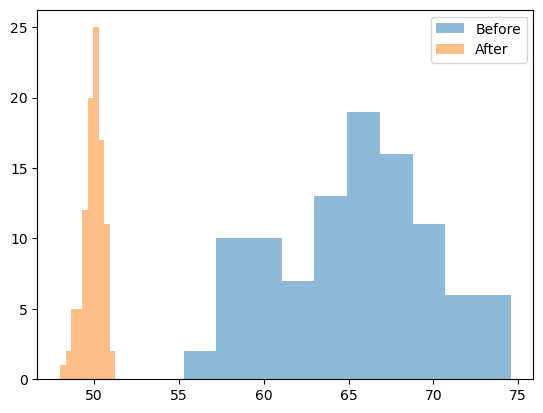

In [10]:
plt.hist(pre_task_accuracies, bins=10, alpha=0.5, label='Before')
plt.hist(task_accuracies, bins=10, alpha=0.5, label='After')
plt.legend()

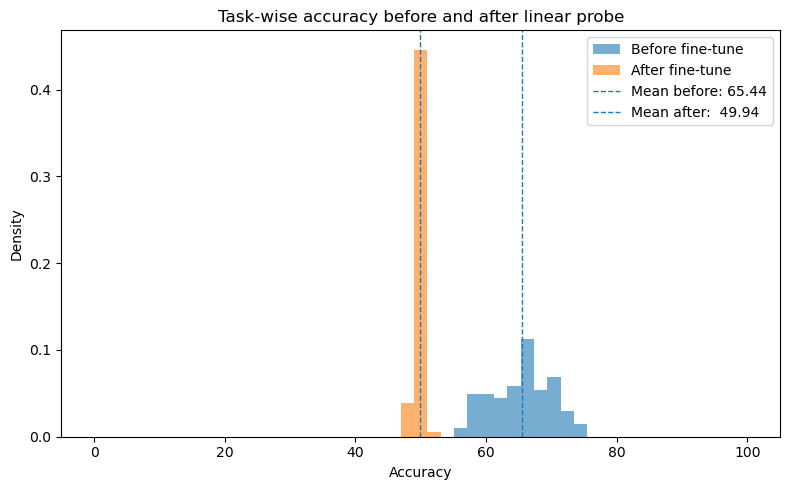

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# ── use identical bin edges so the bars line up ──
bins = np.linspace(0, 100, 50)              # 0 – 1 in 5-point steps

plt.hist(pre_task_accuracies, bins=bins,
         alpha=0.6, density=True,
         label='Before fine-tune')

plt.hist(task_accuracies,     bins=bins,
         alpha=0.6, density=True,
         label='After fine-tune')

# ── mark the means ──
plt.axvline(np.mean(pre_task_accuracies),  linestyle='--', linewidth=1,
            label=f"Mean before: {np.mean(pre_task_accuracies):.2f}")
plt.axvline(np.mean(task_accuracies),      linestyle='--', linewidth=1,
            label=f"Mean after:  {np.mean(task_accuracies):.2f}")

plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Task-wise accuracy before and after linear probe')
plt.legend()
plt.tight_layout()
plt.show()